In [25]:
%matplotlib widget
import spb
import sympy as sp
from sympy import sin, cos, pi, sqrt, acos, simplify
sp.init_printing()

In [26]:
# Helper functions
from typing import List


def homogeneous(rotation: sp.Matrix = sp.eye(3), translation: sp.Matrix = sp.zeros(3, 1)) -> sp.Matrix:
    return rotation.row_join(translation).col_join(sp.Matrix([[0, 0, 0, 1]]))

def dh(rotation, twist, displacement, offset):
    rotation_mat = sp.Matrix([
        [cos(rotation), -sin(rotation)*cos(twist),  sin(rotation)*sin(twist)],
        [sin(rotation), cos(rotation)*cos(twist),   -cos(rotation)*sin(twist)],
        [0,             sin(twist),                 cos(twist)],
    ])
    translation = sp.Matrix([
        [offset*cos(rotation)],
        [offset*sin(rotation)],
        [displacement],
    ])
    return rotation_mat, translation

def rotation(homogeneous: sp.Matrix):
    return homogeneous[:3, :3]

def translation(homogeneous: sp.Matrix):
    return homogeneous[:3, 3:]

def jacobian(transforms: List[sp.Matrix], joint_types: List[sp.Matrix], base_z: sp.Matrix = sp.Matrix([0, 0, 1])):
    transforms_chained = [homogeneous()]
    z_unit_vecs = []
    # chain the transforms
    for i, transform in enumerate(transforms):
        transforms_chained.append(transforms_chained[-1] * transform)
    # apply rotation of chained transforms to base z
    for chained_transform in transforms_chained:
        z_unit_vecs.append(rotation(chained_transform) * base_z)
    
    assert len(transforms_chained) == len(z_unit_vecs)

    jacobian = sp.zeros(6, len(transforms))
    for i, (transform, joint_type) in enumerate(zip(transforms, joint_types)):
        p = 1 if joint_type == 'revolute' else 0
        if joint_type == 'revolute':
            jacobian[:3, i] = z_unit_vecs[i].cross(translation(transforms_chained[-1]) - translation(transforms_chained[i]))
            jacobian[3:, i] = z_unit_vecs[i]
        elif joint_type == 'prismatic':
            jacobian[:3, i] = z_unit_vecs[i]
            jacobian[3:, i] = sp.Matrix([[0], [0], [0]])

        # angular velocity

    return jacobian

In [27]:
q_1, q_2 = sp.symbols('q_1 q_2')
shoulder_rot, shoulder_trans = dh(q_1, -pi/2, 0, 0)
probe_rot, probe_trans = dh(0, pi/2, q_2, 0)
shoulder_tf = homogeneous(shoulder_rot, shoulder_trans)
probe_tf = homogeneous(probe_rot, probe_trans)
base_to_end_tf = shoulder_tf * probe_tf

display(shoulder_tf)
display(probe_tf)
display(base_to_end_tf)
display(shoulder_rot * probe_rot)



⎡cos(q₁)  0   -sin(q₁)  0⎤
⎢                        ⎥
⎢sin(q₁)  0   cos(q₁)   0⎥
⎢                        ⎥
⎢   0     -1     0      0⎥
⎢                        ⎥
⎣   0     0      0      1⎦

⎡1  0  0   0 ⎤
⎢            ⎥
⎢0  0  -1  0 ⎥
⎢            ⎥
⎢0  1  0   q₂⎥
⎢            ⎥
⎣0  0  0   1 ⎦

⎡cos(q₁)  -sin(q₁)  0  -q₂⋅sin(q₁)⎤
⎢                                 ⎥
⎢sin(q₁)  cos(q₁)   0  q₂⋅cos(q₁) ⎥
⎢                                 ⎥
⎢   0        0      1       0     ⎥
⎢                                 ⎥
⎣   0        0      0       1     ⎦

⎡cos(q₁)  -sin(q₁)  0⎤
⎢                    ⎥
⎢sin(q₁)  cos(q₁)   0⎥
⎢                    ⎥
⎣   0        0      1⎦

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

⎡-q₂⋅cos(q₁)  -sin(q₁)⎤
⎢                     ⎥
⎣-q₂⋅sin(q₁)  cos(q₁) ⎦

⎡-cos(q₁)   -sin(q₁) ⎤
⎢─────────  ─────────⎥
⎢    q₂         q₂   ⎥
⎢                    ⎥
⎣-sin(q₁)    cos(q₁) ⎦

In [ ]:
z = sp.Matrix([[0], [0], [1]])
display((shoulder_rot * z).cross(translation(base_to_end_tf)))

⎡-q₂⋅cos(q₁)  -sin(q₁)⎤
⎢                     ⎥
⎣-q₂⋅sin(q₁)  cos(q₁) ⎦

⎡-cos(q₁)   -sin(q₁) ⎤
⎢─────────  ─────────⎥
⎢    q₂         q₂   ⎥
⎢                    ⎥
⎣-sin(q₁)    cos(q₁) ⎦

⎡-(vₓ⋅cos(q₁) + v_y⋅sin(q₁)) ⎤
⎢────────────────────────────⎥
⎢             q₂             ⎥
⎢                            ⎥
⎣ -vₓ⋅sin(q₁) + v_y⋅cos(q₁)  ⎦

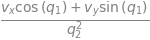

In [40]:
v_x, v_y = sp.symbols('v_x v_y')

base_to_end_jac = simplify(jacobian([shoulder_tf, probe_tf], ['revolute', 'prismatic'])[:2, :2])
base_to_end_jac_inv = simplify(base_to_end_jac.inv())
display(base_to_end_jac)
display(base_to_end_jac_inv)
base_to_end_jac_inv_expr = simplify(base_to_end_jac_inv * sp.Matrix([[v_x], [v_y]]))
display(base_to_end_jac_inv_expr)
display(simplify(base_to_end_jac_inv_expr[0, 0].diff(q_1)))
display(simplify(base_to_end_jac_inv_expr[0, 0].diff(q_2)))
